# Trabalho Individual 2- Optimização Heurística

# Trabalho realizado por:
- # \textit{ João Francisco Botas, nº104782, CDB1}






Foi utilizada uma versão superior à 3.9 para executar alguns comandos especiais que não funcionam em versões anteriores.

### Aplicação da heurística

In [1]:
import pandas as pd
import random
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import time

distance_matrix = pd.read_excel('OH_individual2_104782.xlsx', sheet_name="Tabela")  # instalar openpyxl
distance_matrix.index += 1
nodes = len(distance_matrix)
cientistas=distance_matrix.to_numpy()

apt_media = np.mean(cientistas, axis=1) # cálculo das médias
idx_sorted = np.argsort(apt_media) # ordenar vetor
projetos = np.arange(nodes)  # Índices dos projetos
solucao = np.zeros(nodes, dtype=int)  # Vetor de zeros para solução resultada

for cientist_idx in idx_sorted:
    proj_available = np.argsort(cientistas[cientist_idx])[::-1]  # projetos ordem decrescente de aptidão
    for proj_idx in proj_available:
        if projetos[proj_idx] != 99:  # se já foi atribuído (=99)
            solucao[cientist_idx] = projetos[proj_idx] + 1 # alterar índice
            projetos[proj_idx] = 99  # atribui o projeto para 99
            break
solucao=solucao.tolist()


def calcular_aptidao_total(solucao): # função para cálculo do nível de aptidão
    solucao = np.array(solucao) - 1
    nivel_aptidao = np.sum(cientistas[np.arange(len(cientistas)), solucao])
    return nivel_aptidao            
            
# todos os projetos atribuídos , vetor só com 99's            
print("Solução inicial:",solucao) 
print("Nível de aptidão da heurística utilizada:",calcular_aptidao_total(solucao))

def chunks(solucao):
    """Gerar todas as trocas possíveis entre cientistas"""
    swap_list = []
    num_projects = distance_matrix.shape[1]
    for i in range(num_projects):
        for j in range(i+1, num_projects):
            vizinho = solucao.copy()
            vizinho[i], vizinho[j] = vizinho[j], vizinho[i]
            swap_list.append([i, j])  # Armazena os índices trocados
    return swap_list

# chunks(solucao)

Solução inicial: [10, 2, 9, 8, 4, 5, 6, 3, 1, 7]
Nível de aptidão da heurística utilizada: 886


### Implementação do algoritmo tabu

In [2]:
solucao_atual = [10, 2, 9, 8, 4, 5, 6, 3, 1, 7]
tamanho_lista_tabu = 3
numero_max_iteracoes = 100

lista_tabu: list[list[int, int]] = []  # Lista tabu inicialmente vazia
melhor_solucao = solucao_atual.copy()  # Melhor solução encontrada inicialmente é a solução atual
melhor_aptidao_total = calcular_aptidao_total(melhor_solucao)
melhor_chunk = (0,0)
tempo_acumulado = 0

# Loop principal do algoritmo
iteracao = 0
# Guardar as informações para o dataframe nas iterações
iteracoes_data = []

while iteracao < numero_max_iteracoes:
    start_time = time.time() # tempo inicial
    # Obter todas as soluções vizinhas da solução atual
    chunkss: list[list[int, int]] = chunks(solucao_atual)
    
    melhor_vizinho: list[int, int] = None
    melhor_aptidao_vizinhanca: float = float('-inf')
    
    # Verificar cada solução vizinha
    for chunk in chunkss:
        # Verificar se a solução vizinha não está na lista tabu
        if chunk not in lista_tabu:
            vizinho = solucao_atual.copy()
            vizinho[chunk[0]], vizinho[chunk[1]] = vizinho[chunk[1]], vizinho[chunk[0]]
            """# print(vizinho)
            # print(chunk)
            # print(lista_tabu)""" # apenas para visualização na execução
            aptidao_vizinho = calcular_aptidao_total(vizinho)
            
            # Verificar se a solução vizinha é melhor que a melhor vizinhança atual
            if melhor_vizinho is None or aptidao_vizinho > melhor_aptidao_vizinhanca:
                melhor_chunk = chunk
                melhor_vizinho = vizinho
                melhor_aptidao_vizinhanca = aptidao_vizinho
    
    # Atualizar a lista tabu adicionando a última troca realizada
    lista_tabu.append(melhor_chunk)
    
    # Verificar se a lista tabu excedeu o tamanho máximo permitido
    if len(lista_tabu) > tamanho_lista_tabu:
        # Remover o movimento mais antigo da lista tabu, dado o tamanho da lista
        lista_tabu.pop(0)
    
    # Atualizar a solução atual para o melhor vizinho encontrado
    solucao_atual = melhor_vizinho
    
    
    # Verificar se o melhor vizinho encontrado é melhor que a melhor solução conhecida
    if melhor_aptidao_vizinhanca > melhor_aptidao_total:
        melhor_solucao = melhor_vizinho.copy()
        melhor_aptidao_total = melhor_aptidao_vizinhanca
        max_iteration = iteracao + 1 # consertar com o index do dataframe, que começa em 0 por defeito 
    
    # Guardar a informação da lista tabu na forma de (Cx,Cy)
    lista_tabu_strings = [f"(C{sublist[0] + 1}, C{sublist[1] + 1})" for sublist in lista_tabu]
    
    # Incrementar o número de iterações
    iteracao += 1
    
    end_time = time.time()
    tempo_decorrido = end_time - start_time
    
    tempo_acumulado += tempo_decorrido
    
    # Adicionar a linha ao dataframe
    iteracao_data = {
        'Iteração': iteracao,
        'Lista Tabu': lista_tabu_strings.copy(),
        'Solução Atual': solucao_atual.copy(),
        'Aptidão Total': melhor_aptidao_vizinhanca,
    }

    # Adicionar os dados da iteração à lista de dados
    iteracoes_data.append(iteracao_data)
    
    
# Converter a lista de dados em um DataFrame
df_iteracoes = pd.DataFrame(iteracoes_data)
df_iteracoes = df_iteracoes.set_index('Iteração')


# Imprimir a melhor solução encontrada
print("="*60)
print(f"Solução inicial: \033[1m{solucao}\033[0m")
print(f"Nível de aptidão total da solução inicial: \033[1m{calcular_aptidao_total(solucao)}\033[0m")
print("Começando na \033[4m1ª iteração\033[0m...")
print("="*60)
print(f"Melhor solução encontrada: \033[1m{melhor_solucao}\033[0m")
print(f"Nível de aptidão total da melhor solução: \033[1m{melhor_aptidao_total}\033[0m")
print(f"Iteração em que a melhor aptidão foi gerada: \033[1m{max_iteration}\033[0m")
print(f"Demorou cerca de \033[1m{round(tempo_acumulado, 3)} segundos\033[0m a realizar as \033[4m100 iterações\033[0m.")
print("="*60)

Solução inicial: [10, 2, 9, 8, 4, 5, 6, 3, 1, 7]
Nível de aptidão total da solução inicial: 886
Começando na 1ª iteração...
Melhor solução encontrada: [9, 2, 6, 8, 7, 4, 10, 3, 1, 5]
Nível de aptidão total da melhor solução: 902
Iteração em que a melhor aptidão foi gerada: 14
Demorou cerca de 0.173 segundos a realizar as 100 iterações.


In [3]:
# Imprimir o DataFrame com os dados de cada iteração com uma estrutura de visualização
rai = ['#FF0000', '#FF7F00', '#FFFF00', '#00FF00', '#0000FF', '#4B0082', '#8B00FF']
cell_hover = {
    "selector": "td:hover",
    "props": [("background-color", "#BFDDF3")]
}
index_names = {
    "selector": ".index_name",
    "props": "font-style: italic; color: black; font-weight:normal"
}
headers = {
    "selector": "th:not(.index_name)",
    "props": "background-color: #8176C3; color: black;"
}
df_iteracoes_s = df_iteracoes.iloc[:max_iteration]
df_iteracoes_s.style.set_table_styles([cell_hover, index_names, headers])

,Lista Tabu,Solução Atual,Aptidão Total
Iteração,,,
1,"['(C7, C10)']","[10, 2, 9, 8, 4, 5, 7, 3, 1, 6]",889
2,"['(C7, C10)', '(C5, C7)']","[10, 2, 9, 8, 7, 5, 4, 3, 1, 6]",894
3,"['(C7, C10)', '(C5, C7)', '(C2, C10)']","[10, 6, 9, 8, 7, 5, 4, 3, 1, 2]",893
4,"['(C5, C7)', '(C2, C10)', '(C5, C9)']","[10, 6, 9, 8, 1, 5, 4, 3, 7, 2]",890
5,"['(C2, C10)', '(C5, C9)', '(C2, C3)']","[10, 9, 6, 8, 1, 5, 4, 3, 7, 2]",878
6,"['(C5, C9)', '(C2, C3)', '(C3, C10)']","[10, 9, 2, 8, 1, 5, 4, 3, 7, 6]",877
7,"['(C2, C3)', '(C3, C10)', '(C9, C10)']","[10, 9, 2, 8, 1, 5, 4, 3, 6, 7]",875
8,"['(C3, C10)', '(C9, C10)', '(C2, C6)']","[10, 5, 2, 8, 1, 9, 4, 3, 6, 7]",872
9,"['(C9, C10)', '(C2, C6)', '(C1, C6)']","[9, 5, 2, 8, 1, 10, 4, 3, 6, 7]",874


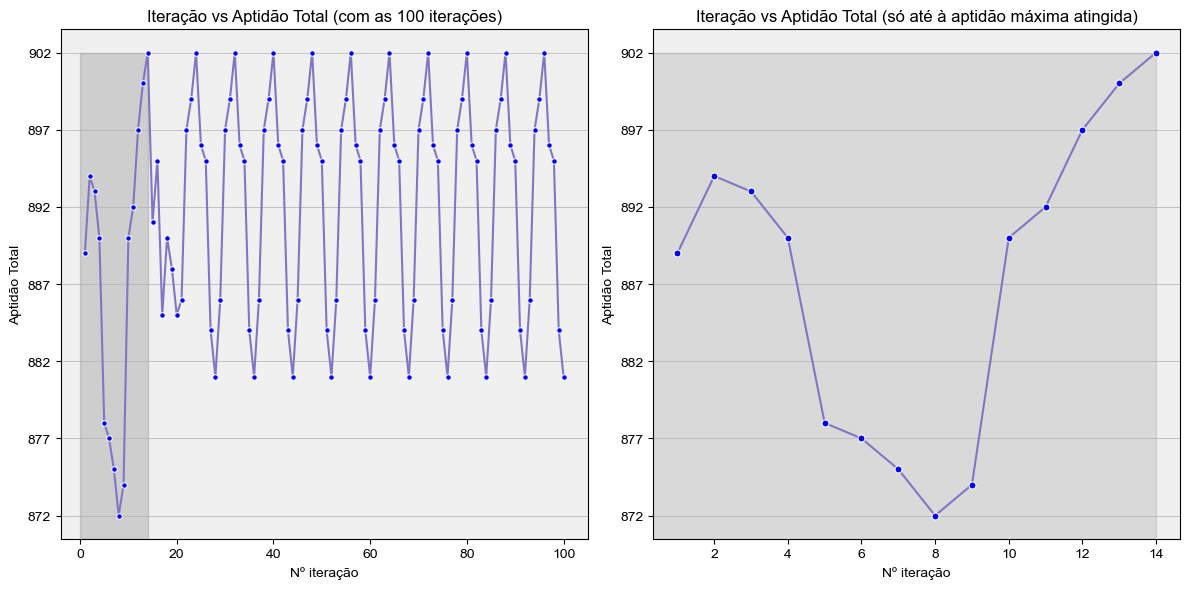

In [4]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
############################################################################################################################
# 1º gráfico
sns.set_style("whitegrid")
sns.set_palette("pastel")
sns.lineplot(data=df_iteracoes, x='Iteração', y='Aptidão Total', marker='o', markersize=4, markerfacecolor="blue",color="#8176C3", ax=axs[0])
indice_maximo = df_iteracoes['Aptidão Total'].idxmax()
valor_maximo = df_iteracoes['Aptidão Total'].max()
retangulo = Rectangle((0, 0), indice_maximo, valor_maximo,
                      alpha=0.3, color='gray')
# labels
axs[0].set_title('Iteração vs Aptidão Total (com as 100 iterações)')
axs[0].set_xlabel('Nº iteração')
axs[0].set_ylabel('Aptidão Total')
axs[0].set_facecolor('#F0F0F0')
axs[0].grid(True, axis='y', which='major', linestyle='-', linewidth=0.5)
axs[0].grid(True, axis='y', which='minor', linestyle='--', linewidth=0.5)
axs[0].set_yticks(range(int(df_iteracoes['Aptidão Total'].min()), int(df_iteracoes['Aptidão Total'].max()) + 1, 5))
axs[0].add_patch(retangulo)
############################################################################################################################
# 2º gráfico
sns.set_style("whitegrid")
sns.set_palette("pastel")
sns.lineplot(data=df_iteracoes_s, x='Iteração', y='Aptidão Total', marker='o', markersize=5,markerfacecolor="blue",color="#8176C3", ax=axs[1])
indice_maximo = df_iteracoes_s['Aptidão Total'].idxmax()
valor_maximo = df_iteracoes_s['Aptidão Total'].max()
retangulo = Rectangle((0, 0), indice_maximo, valor_maximo,
                      alpha=0.2, color='gray')
# labels
axs[1].set_title('Iteração vs Aptidão Total (só até à aptidão máxima atingida)')
axs[1].set_xlabel('Nº iteração')
axs[1].set_ylabel('Aptidão Total')
axs[1].set_facecolor('#F0F0F0')
axs[1].grid(True, axis='y', which='major', linestyle='-', linewidth=0.5)
axs[1].grid(True, axis='y', which='minor', linestyle='--', linewidth=0.5)
axs[1].set_yticks(range(int(df_iteracoes['Aptidão Total'].min()), int(df_iteracoes['Aptidão Total'].max()) + 1, 5))
axs[1].add_patch(retangulo)
############################################################################################################################
plt.tight_layout()
plt.show()